# Проект: Оптимизация управления персоналом (Сборный проект — 2)

В рамках данного проекта предстоит разработать решение, которое позволит бизнесу оптимизировать управление персоналом.

Задачи:

1.Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2.Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Описание данных: 

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

quit — увольнение сотрудника из компании.

План работы:

Задача 1:

Изучить информацию о датафреймах;

Сделать предобработку данных;

Сделать исследовательский анализ данных;

Использовать пайплайны для подготовки данных;

Обучить модели. Выбрать лучшую модель и проверить её качество;

Сделать выводы.

Задача 2:

Изучить информацию о датафреймах;

Сделать предобработку данных;

Сделать исследовательский анализ данных;

Добавить новый входной признак;

Использовать пайплайны для подготовки данных;

Обучить модели. Выбрать лучшую модель и проверить её качество;

Сделать выводы.

In [1]:
!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.5.1 -q
!pip install shap 
!pip install phik

import os
import numpy as np
import pandas as pd
import seaborn as sns
import shap

import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)
from sklearn.impute import SimpleImputer 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy import stats as st

RANDOM_STATE = 42

## Задача 1. Загрузка данных

In [2]:
pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth2 = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'

if os.path.exists(pth1):
    data_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_train = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(data_train.head())
data_train.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [3]:
pth3 = '/datasets/test_features.csv'
pth4 = 'https://code.s3.yandex.net/datasets/test_features.csv'

if os.path.exists(pth3):
    data_test_features = pd.read_csv(pth3)
elif os.path.exists(pth4):
    data_test_features = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
display(data_test_features.head())
data_test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [4]:
pth5 = '/datasets/test_target_job_satisfaction_rate.csv'
pth6 = 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'

if os.path.exists(pth5):
    data_test_rate = pd.read_csv(pth5)
elif os.path.exists(pth6):
    data_test_rate = pd.read_csv(pth6)
else:
    print('Something is wrong')
    
display(data_test_rate.head())
data_test_rate.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Выводы:

В датафрейме data_train 4000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary тип данных int, в столбцах dept, level, workload, last_year_promo, last_year_violations тип данных object, в столбцах job_satisfaction_rat тип данных float.

В датафрейме data_test_features 2000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary  тип данных int, в столбце dept, level, workload, last_year_promo, last_year_violations тип данных object.

В датафрейме data_test_rate 2000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных int, в столбце job_satisfaction_rate тип данных float.

Требуется предобработка данных (проверка наличия пропусков и дубликатов).

##  Предобработка данных

In [5]:
# установим столбец id в качестве индекса
data_train.set_index('id', inplace=True)
data_test_features.set_index('id', inplace=True)
data_test_rate.set_index('id', inplace=True)

In [6]:
# проверяем наличие пропущенных значений в датафреймах
data_train.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [7]:
data_test_features.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [8]:
data_test_rate.isna().sum()

job_satisfaction_rate    0
dtype: int64

In [9]:
# заменим пропуски на nan
data_train['dept'] = data_train['dept'].replace(' ', np.nan)
data_train['level'] = data_train['level'].replace(' ', np.nan)

In [10]:
data_test_features['dept'] = data_test_features['dept'].replace(' ', np.nan)
data_test_features['level'] = data_test_features['level'].replace(' ', np.nan)

In [11]:
# проверяем наличие явных дубликатов в датафреймах
data_train.duplicated().sum()

245

In [12]:
data_test_features.duplicated().sum()

557

In [13]:
data_test_rate.duplicated().sum()

1902

In [14]:
# проверим значения в столбцах
data_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
data_test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [16]:
data_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [17]:
data_test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
# исправим ошибку в написании
data_train.loc[data_train['level'] == 'sinior', 'level'] = 'senior'
data_test_features.loc[data_test_features['level'] == 'sinior', 'level'] = 'senior'

In [19]:
data_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [20]:
data_test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [21]:
# заменим пропуск на nan
data_test_features['workload'] = data_test_features['workload'].replace(' ', np.nan)

In [22]:
data_test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [23]:
data_train.shape

(4000, 9)

In [24]:
data_test_features.shape

(2000, 8)

In [25]:
data_test_rate.shape

(2000, 1)

Выводы:

Были проверено, нет ли пропущенных значений; Проведена замена пробелов на nan. Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели.

Было проверено наличие явных и не явных дубликатов; 

Исправлена ошибка в написании значения.

Данные готовы к исследовательскому анализу.

## Исследовательский анализ данных

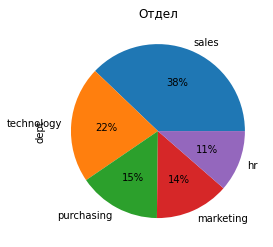

In [26]:
# проведем статистический анализ всех данных
data_train['dept'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Отдел')
plt.show()

38% id из отдела sales, 22% из technology, 15% из purchasing, 14% из marketing, 11% из hr.

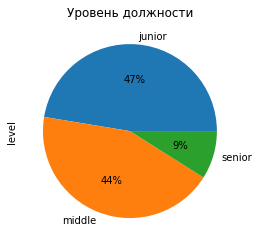

In [27]:
data_train['level'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень должности')
plt.show()

47% id уровня junior, 44% middle, 9% senior.

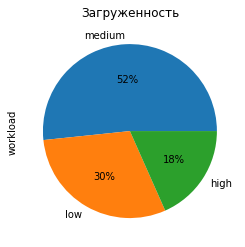

In [28]:
data_train['workload'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Загруженность')
plt.show()

52% id medium загруженности, 30% low, 18% high.

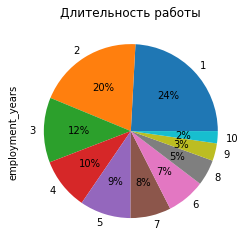

In [29]:
data_train['employment_years'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Длительность работы')
plt.show()

In [30]:
data_train['employment_years'].describe()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3.

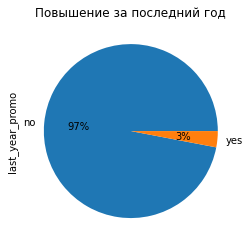

In [31]:
data_train['last_year_promo'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Повышение за последний год')
plt.show()

Только у 3% id было повышение за последний год.

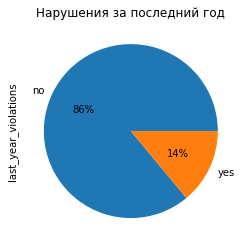

In [32]:
data_train['last_year_violations'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Нарушения за последний год')
plt.show()

Только у 14% id были нарушения трудового договора за последний год.

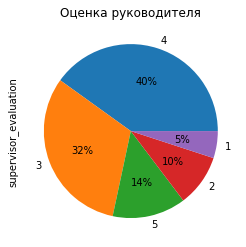

In [33]:
data_train['supervisor_evaluation'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Оценка руководителя')
plt.show()

In [34]:
data_train['supervisor_evaluation'].describe()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4.

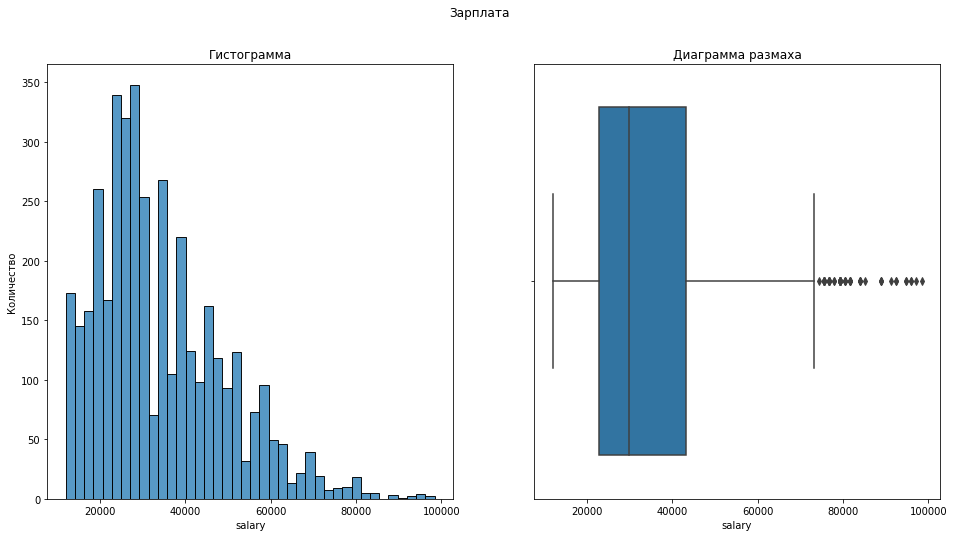

In [35]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_train ,x = 'salary', ax=axs[0], bins = 40)
axs[0].set_xlabel('salary')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_train,x = 'salary', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Зарплата')
plt.show()

In [36]:
data_train['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Зарплата находится в диапазоне от 12000 до 984000, медиана - 30000.

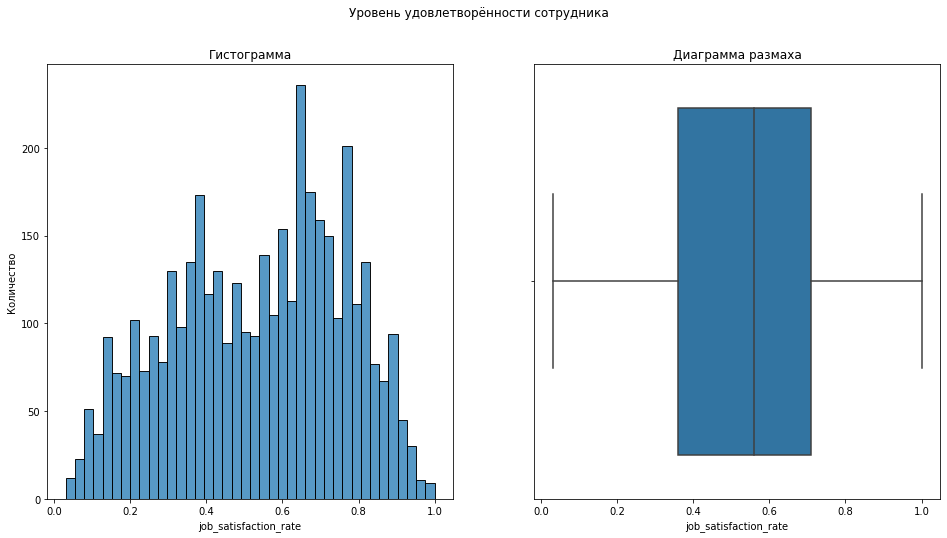

In [37]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_train ,x = 'job_satisfaction_rate', ax=axs[0], bins = 40)
axs[0].set_xlabel('job_satisfaction_rate')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_train,x = 'job_satisfaction_rate', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Уровень удовлетворённости сотрудника')
plt.show()

In [38]:
data_train['job_satisfaction_rate'].describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.56.

In [39]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = data_train.phik_matrix(interval_cols=['salary','job_satisfaction_rate'])

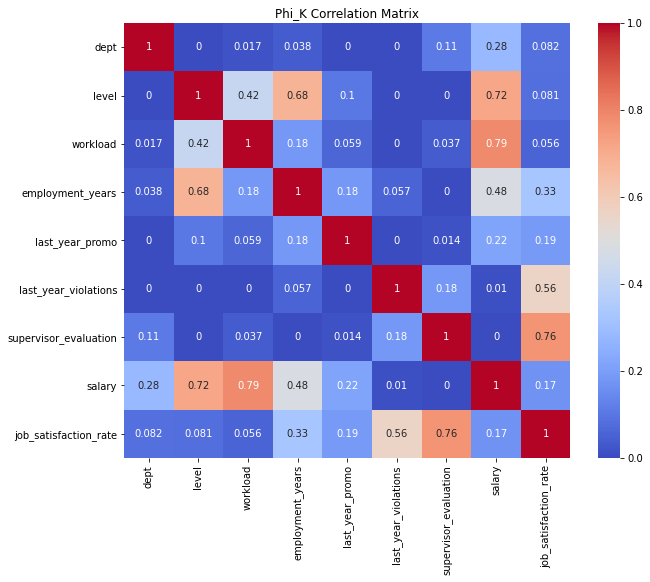

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

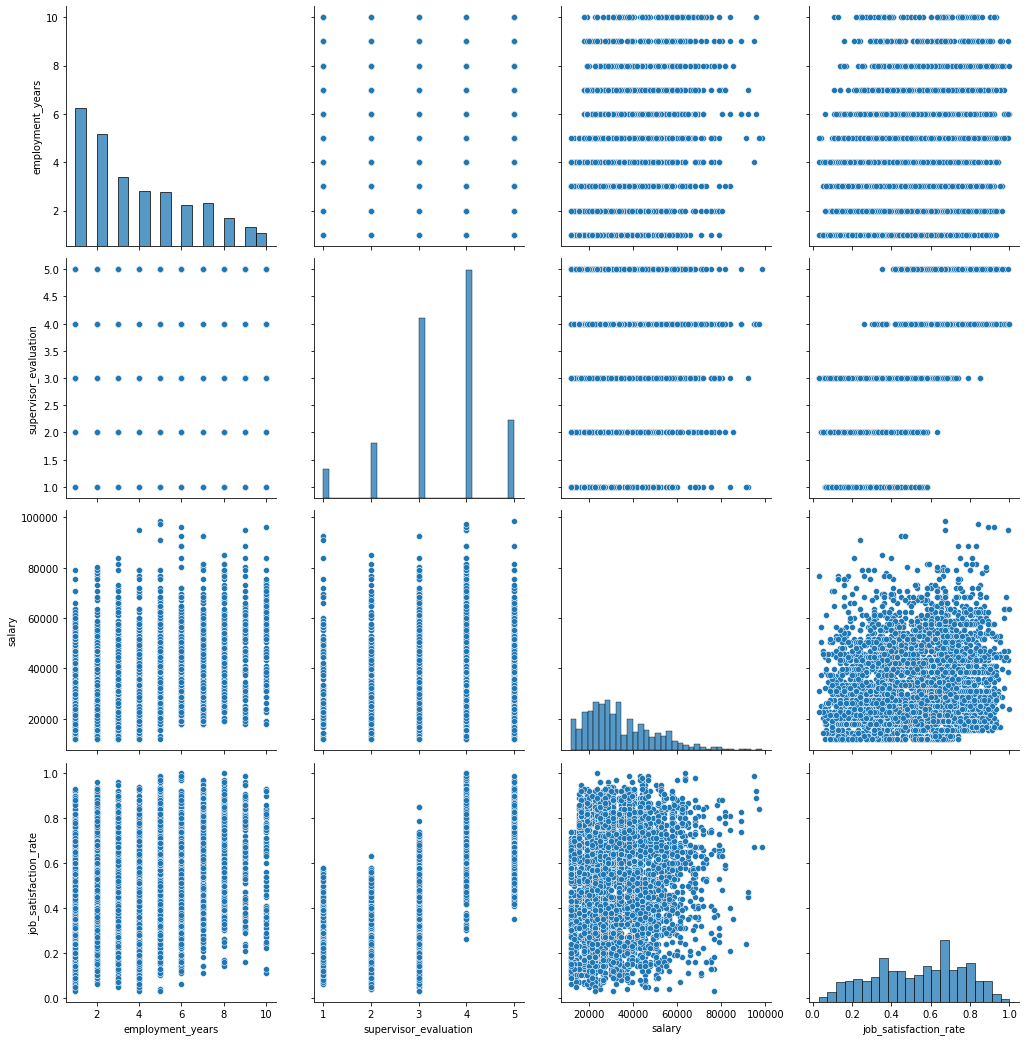

In [41]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data_train[['employment_years', 'supervisor_evaluation','salary','job_satisfaction_rate']])
plt.gcf().set_size_inches(15,15);

У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76).
Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.71, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.

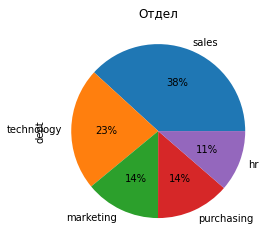

In [42]:
# проведем статистический анализ test выборки
data_test_features['dept'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Отдел')
plt.show()

38% id из отдела sales, 23% из technology, 14% из purchasing, 14% из marketing, 11% из hr.

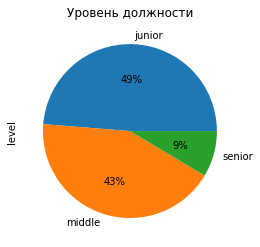

In [43]:
data_test_features['level'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень должности')
plt.show()

49% id уровня junior, 43% middle, 9% senior.

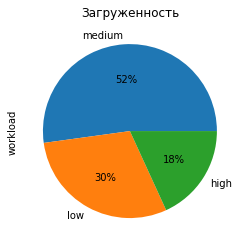

In [44]:
data_test_features['workload'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Загруженность')
plt.show()

52% id medium загруженности, 30% low, 18% high.

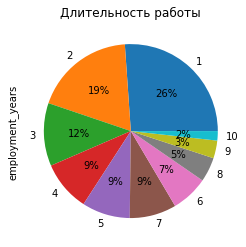

In [45]:
data_test_features['employment_years'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Длительность работы')
plt.show()

In [46]:
data_test_features['employment_years'].describe()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3.

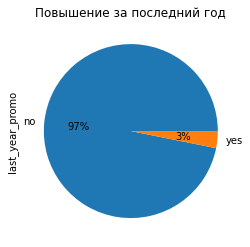

In [47]:
data_test_features['last_year_promo'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Повышение за последний год')
plt.show()

Только у 3% id было повышение за последний год.

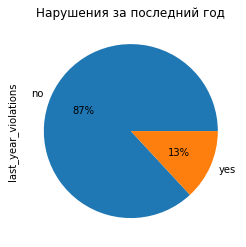

In [48]:
data_test_features['last_year_violations'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Нарушения за последний год')
plt.show()

Только у 13% id были нарушения трудового договора за последний год.

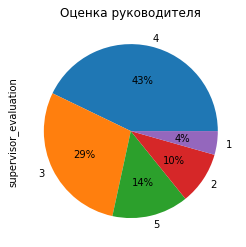

In [49]:
data_test_features['supervisor_evaluation'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Оценка руководителя')
plt.show()

In [50]:
data_test_features['supervisor_evaluation'].describe()

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4.

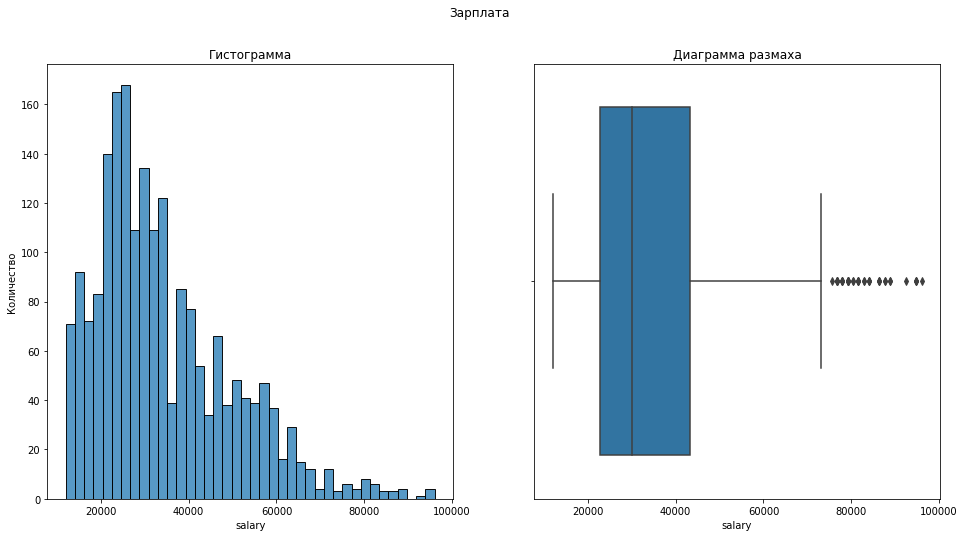

In [51]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_test_features ,x = 'salary', ax=axs[0], bins = 40)
axs[0].set_xlabel('salary')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_test_features,x = 'salary', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Зарплата')
plt.show()

In [52]:
data_test_features['salary'].describe()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000.

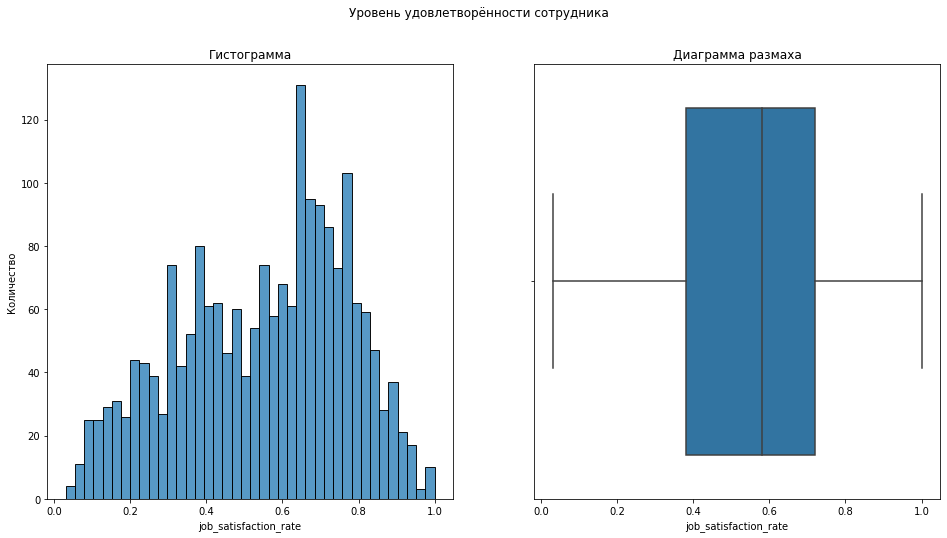

In [53]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_test_rate ,x = 'job_satisfaction_rate', ax=axs[0], bins = 40)
axs[0].set_xlabel('job_satisfaction_rate')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_test_rate,x = 'job_satisfaction_rate', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Уровень удовлетворённости сотрудника')
plt.show()

In [54]:
data_test_rate['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.58.

In [55]:
test_df = data_test_features.merge(data_test_rate, on='id')
test_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


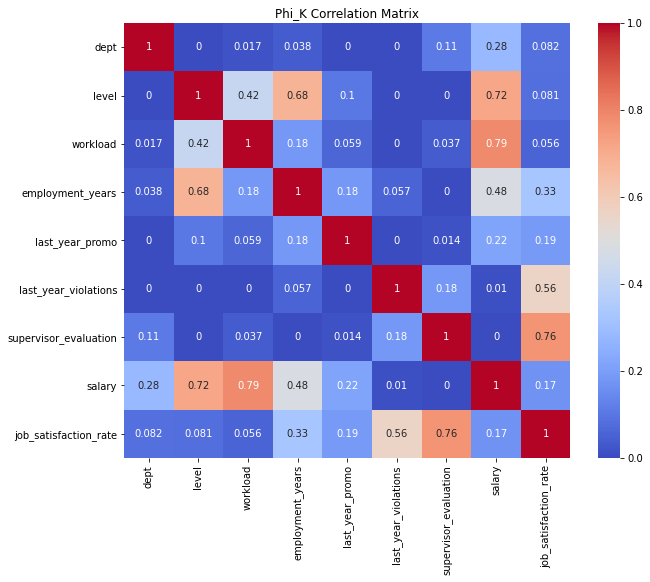

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

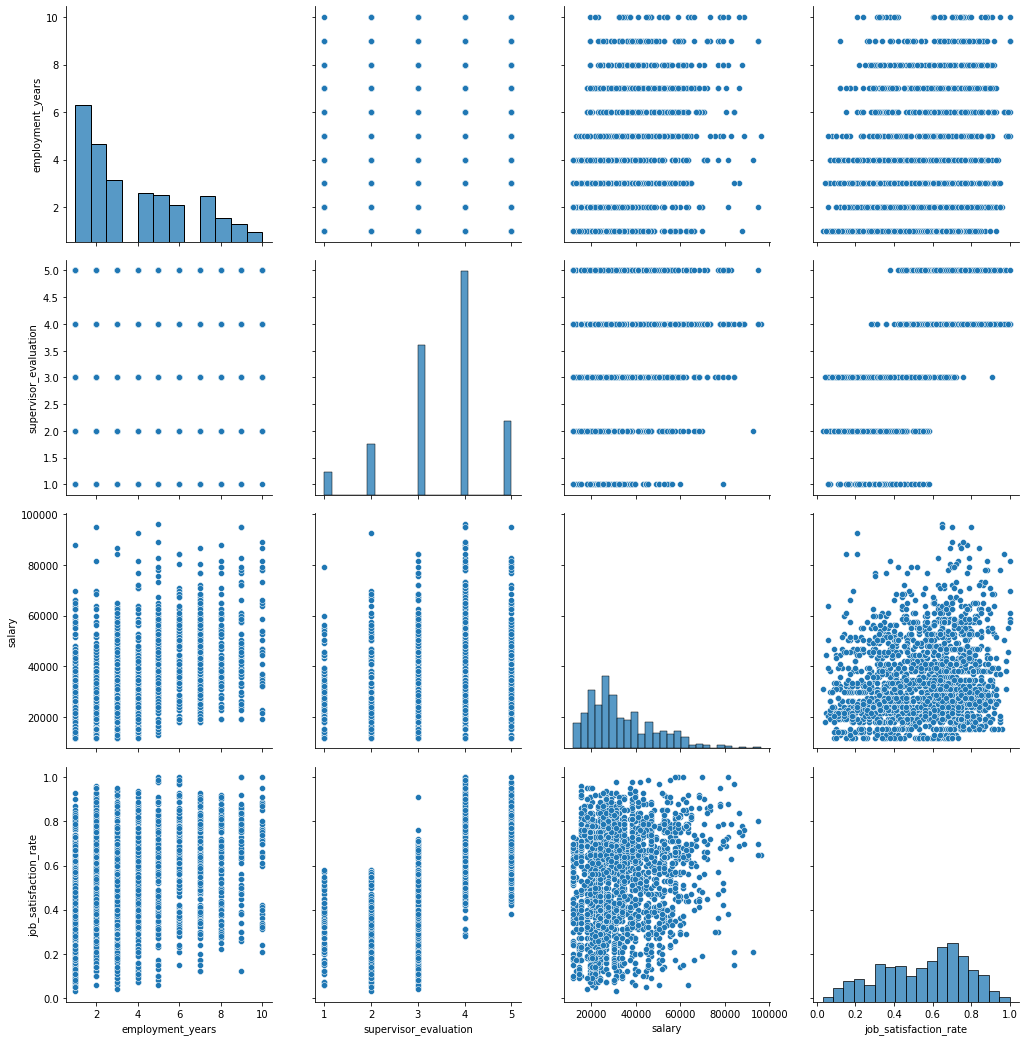

In [57]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(test_df[['employment_years', 'supervisor_evaluation','salary','job_satisfaction_rate']])
plt.gcf().set_size_inches(15,15);

У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76). Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.72, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.

Выводы:

38% id из отдела sales, 22% из technology, 15% из purchasing, 14% из marketing, 11% из hr. 47% id уровня junior, 44% middle, 9% senior. 52% id medium загруженности, 30% low, 18% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год.Только у 14% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 984000, медиана - 30000. Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.56. У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76).
Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.71, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.

Статистический анализ test выборки показал, что 38% id из отдела sales, 23% из technology, 14% из purchasing, 14% из marketing, 11% из hr. 9% id уровня junior, 43% middle, 9% senior. 52% id medium загруженности, 30% low, 18% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год. Только у 13% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000. Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.58. У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76). Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.72, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.

##  Использование пайплайнов

In [58]:
# удалим дубликаты в data_train
data_train = data_train.drop_duplicates()

In [59]:
data_train.shape

(3755, 9)

In [60]:
# создадим списки с названиями признаков и разделим данные на обучающую и тестовую выборки
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

y = data_train['job_satisfaction_rate']
X = data_train.drop(['job_satisfaction_rate'], axis=1)
y_test = data_test_rate
X_test = data_test_features

Приступим к созданию пайплайна подготовки данных (на этом этапе нужно заполнить пропуски).
Для подготовки признаков будем использовать:
MinMaxScaler/StandartScaler для стобцов employment_years, salary, supervisor_evaluation.
OrdinalEncoder для столбцов level, workload.
OneHotEncoder для столбцов dept, last_year_promo, last_year_violations.

In [61]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 


In [62]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [63]:
# объединяем все пайплайны с помощью ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

## Обучение моделей

In [64]:
# итоговый пайплайн
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [65]:
# словари для моделей DecisionTreeClassifier(), LinearRegression()
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [66]:
# функция вычисления SMAPE
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape_score, greater_is_better = False)

In [67]:
grid_search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring=smape_scorer, 
    n_jobs=-1
)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                          'models__max_depth': [None, 2, 3, 4, 5, 6],
                          'models__min_samples_split': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [68]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['supervisor_evaluation',
                                                   'employment_years',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(min_samples_split=8, random_state=42))])

In [69]:
print(f'Метрика лучшей модели на кросс-валидации: {-grid_search.best_score_}')

Метрика лучшей модели на кросс-валидации: 15.066131118340204


In [70]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()

In [71]:
y_predict = grid_search.predict(X_test)

In [72]:
smape_score(np.array(y_test['job_satisfaction_rate']), y_predict)

13.581003491925054

In [73]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
dummy_regr.predict(X)
dummy_regr.score(X, y)

0.0

In [74]:
predictions_dum = dummy_regr.predict(X_test)
smape_score(np.array(y_test['job_satisfaction_rate']), predictions_dum)

38.26225790202238

## Выводы

В данном шаге была найдена и обучена лучшая модель по предсказанию уровня удовлетворённости сотрудника работой. Значение метрики на тестовой выборке составляет 13.6, что является успехом, ведь для неё необходимо значение меньше 15. Лучшей моделью стала DecisionTreeRegressor(min_samples_split=8, random_state=42).

## Задача 2. Загрузка данных

In [75]:
pth7 = '/datasets/train_quit.csv'
pth8 = 'https://code.s3.yandex.net/datasets/train_quit.csv'

if os.path.exists(pth1):
    data_train_quit = pd.read_csv(pth7)
elif os.path.exists(pth2):
    data_train_quit = pd.read_csv(pth8)
else:
    print('Something is wrong')
    
display(data_train_quit.head())
data_train_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [76]:
pth9 = '/datasets/test_target_quit.csv'
pth10 = 'https://code.s3.yandex.net/datasets/test_target_quit.csv'

if os.path.exists(pth1):
    data_target_quit = pd.read_csv(pth9)
elif os.path.exists(pth2):
    data_target_quit = pd.read_csv(pth10)
else:
    print('Something is wrong')
    
display(data_target_quit.head())
data_target_quit.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Выводы:

В датафрейме data_train_quit 4000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary тип данных int, в столбцах dept, level, workload, last_year_promo, last_year_violations, quit тип данных object.

В датафрейме data_target_quit 2000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных int, в столбце quit тип данных object.

Требуется предобработка данных (проверка наличия пропусков и дубликатов).

## Предобработка данных

In [77]:
# установим столбец id в качестве индекса
data_train_quit.set_index('id', inplace=True)
data_target_quit.set_index('id', inplace=True)

In [78]:
# проверяем наличие пропущенных значений в датафреймах
data_train_quit.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [79]:
data_target_quit.isna().sum()

quit    0
dtype: int64

In [80]:
# проверяем наличие явных дубликатов в датафреймах
data_train_quit.duplicated().sum()

1413

In [81]:
data_target_quit.duplicated().sum()

1998

In [82]:
# проверим значения в столбцах
data_train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [83]:
data_train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [84]:
# исправим ошибку в написании
data_train_quit.loc[data_train_quit['level'] == 'sinior', 'level'] = 'senior'

In [85]:
data_train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [86]:
data_train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [87]:
data_train_quit.shape

(4000, 9)

In [88]:
data_target_quit.shape

(2000, 1)

Выводы:

Были проверено, нет ли пропущенных значений; 

Было проверено наличие явных и не явных дубликатов;

Исправлена ошибка в написании значения.

Данные готовы к исследовательскому анализу.

## Исследовательский анализ данных

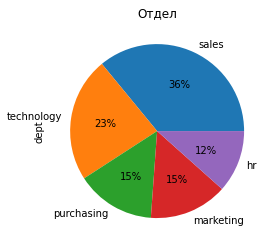

In [89]:
# проведем статистический анализ всех данных
data_train_quit['dept'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Отдел')
plt.show()

36% id из отдела sales, 23% из technology, 15% из purchasing, 15% из marketing, 12% из hr.

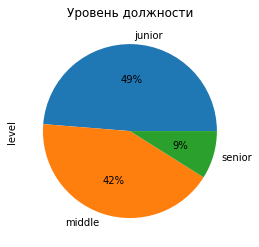

In [90]:
data_train_quit['level'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень должности')
plt.show()

49% id уровня junior, 42% middle, 9% senior.

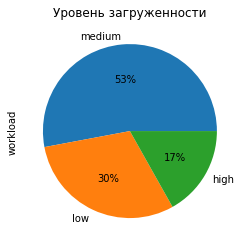

In [91]:
data_train_quit['workload'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень загруженности')
plt.show()

53% id medium загруженности, 30% low, 17% high.

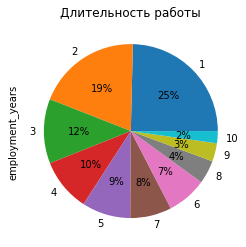

In [92]:
data_train_quit['employment_years'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Длительность работы')
plt.show()

In [93]:
data_train_quit['employment_years'].describe()

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3.

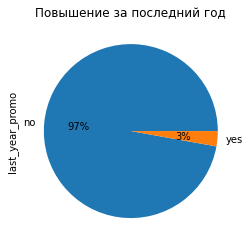

In [94]:
data_train_quit['last_year_promo'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Повышение за последний год')
plt.show()

Только у 3% id было повышение за последний год.

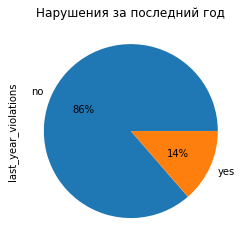

In [95]:
data_train_quit['last_year_violations'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Нарушения за последний год')
plt.show()

У 14% id были нарушения трудового договора за последний год.

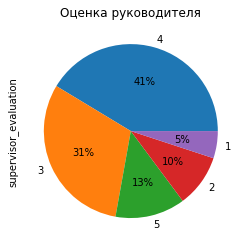

In [96]:
data_train_quit['supervisor_evaluation'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Оценка руководителя')
plt.show()

In [97]:
data_train_quit['supervisor_evaluation'].describe()

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4.

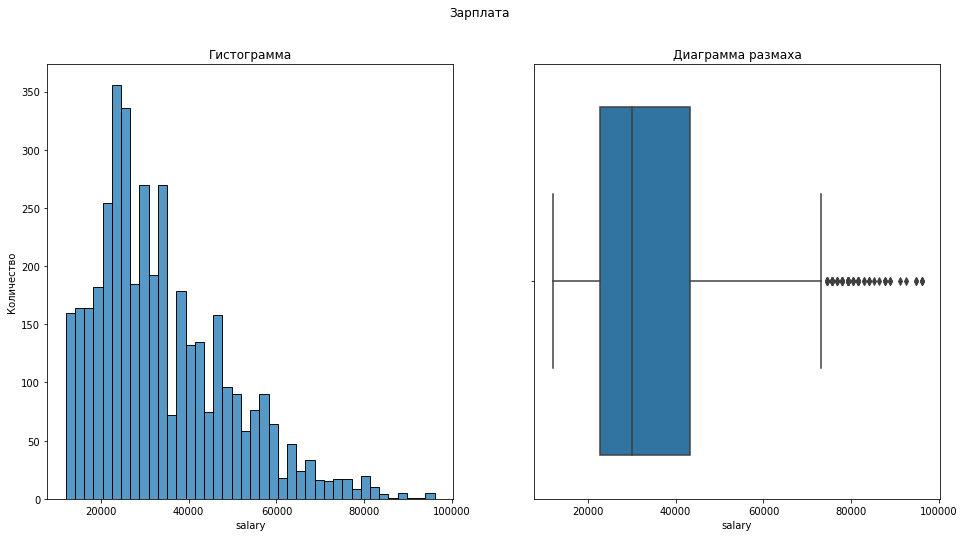

In [98]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_train_quit ,x = 'salary', ax=axs[0], bins = 40)
axs[0].set_xlabel('salary')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_train_quit,x = 'salary', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Зарплата')
plt.show()

In [99]:
data_train_quit['salary'].describe()

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000.

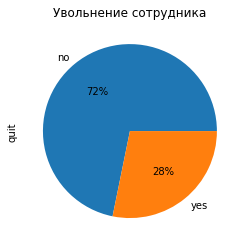

In [100]:
data_train_quit['quit'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Увольнение сотрудника')
plt.show()

28% id уволились.

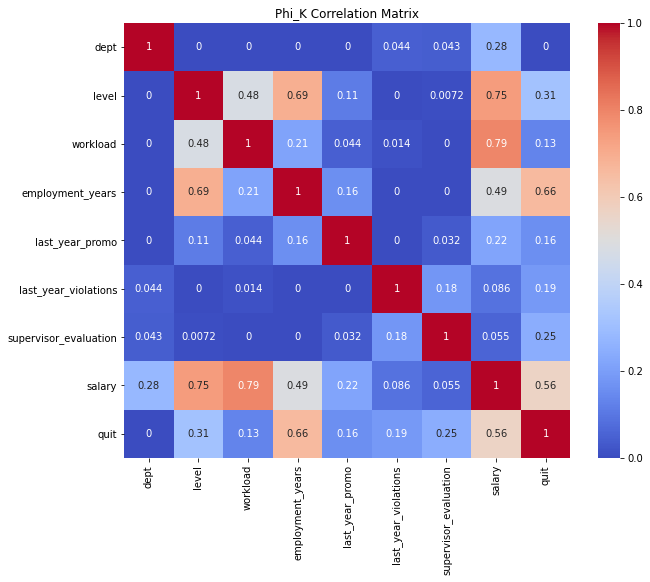

In [101]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = data_train_quit.phik_matrix(interval_cols=['employment_years',
                                                    'supervisor_evaluation','salary','job_satisfaction_rate'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

У длительности работы сотрудника высокая корреляция с показателем увольнения (0.66).

In [102]:
# cоставим портрет «уволившегося сотрудника»
analysis_quit = data_train_quit[data_train_quit['quit'] == 'yes']

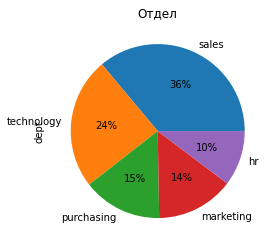

In [103]:
analysis_quit['dept'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Отдел')
plt.show()

36% уволившихся из отдела sales, 24% из technology, 15% из purchasing, 14% из marketing, 10% из hr.

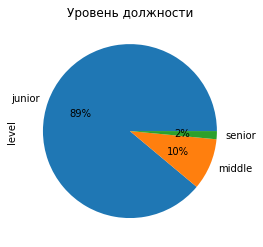

In [104]:
analysis_quit['level'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень должности')
plt.show()

Среди уволившихся были 89% junior, 10% middle и 2% senior.

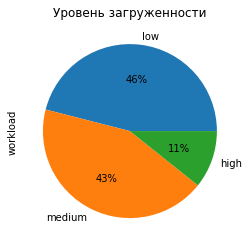

In [105]:
analysis_quit['workload'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Уровень загруженности')
plt.show()

46% уволившихся low загруженности, 43% medium, 11% high.

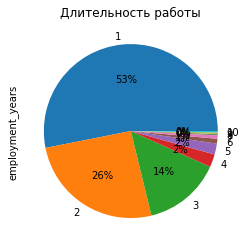

In [106]:
analysis_quit['employment_years'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Длительность работы')
plt.show()

In [107]:
analysis_quit['employment_years'].describe()

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

Длительность работы в компании у уволившихся находится в диапазоне от 1 до 10, медиана - 1 (53%).

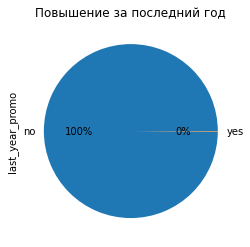

In [108]:
analysis_quit['last_year_promo'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Повышение за последний год')
plt.show()

У 100% уволившихся не было повышения за последний год.

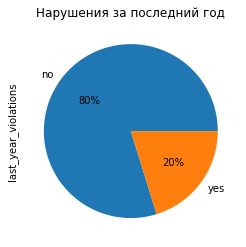

In [109]:
analysis_quit['last_year_violations'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Нарушения за последний год')
plt.show()

У 80% уволившихся были нарушения трудового договора за последний год.

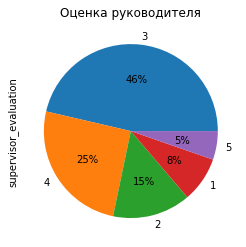

In [110]:
analysis_quit['supervisor_evaluation'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Оценка руководителя')
plt.show()

In [111]:
analysis_quit['supervisor_evaluation'].describe()

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 3 (у 46% оценка 3). 

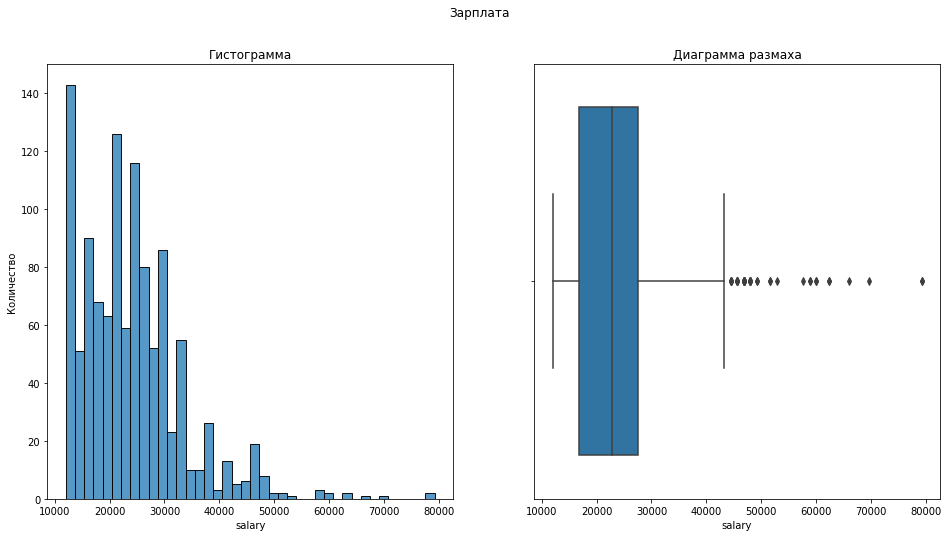

In [112]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = analysis_quit ,x = 'salary', ax=axs[0], bins = 40)
axs[0].set_xlabel('salary')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = analysis_quit,x = 'salary', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Зарплата')
plt.show()

In [113]:
analysis_quit['salary'].describe()

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

Зарплата уволившихся находится в диапазоне от 12000 до 79200, медиана - 22800.

In [114]:
no = data_train_quit.loc[data_train_quit['quit'] == 'no', 'salary'].mean()
yes = data_train_quit.loc[data_train_quit['quit'] == 'yes', 'salary'].mean()
print ('Средняя зарплата неуволившихся сотрудников:', no)
print ('Средняя зарплата уволившихся сотрудников:', yes)

Средняя зарплата неуволившихся сотрудников: 37702.22841225627
Средняя зарплата уволившихся сотрудников: 23885.106382978724


In [115]:
# визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников
data_target_quit = data_target_quit.sort_index()
data_test_features = data_test_features.sort_index()

In [116]:
new_test = data_test_features
new_test['job_satisfaction_rate'] = data_test_rate['job_satisfaction_rate']
new_test['quit'] = data_target_quit['quit']

In [117]:
new_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no


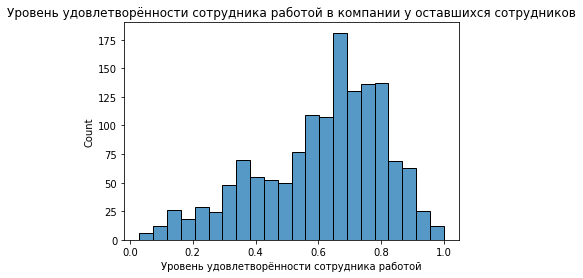

In [118]:
sns.histplot(data = new_test.loc[new_test['quit']=='no'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у оставшихся сотрудников')
plt.show()

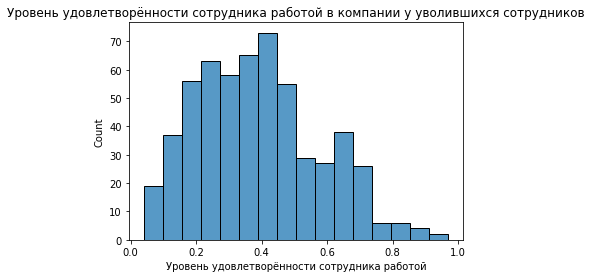

In [119]:
sns.histplot(data = new_test.loc[new_test['quit']=='yes'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у уволившихся сотрудников')
plt.show()

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник: у уволившихся сотрудников в большинстве случаев он меньше 0.5, то у оставшихся - больше 0.6.

Выше ли уровень удовлетворённости сотрудника работой в компании у оставшихся сотрудников?

Нулевая гипотеза - уровни удовлетворенности равны.

Альтернативная гипотеза - средний уровень удовлетворенности работой у оставшихся сотрудников больше среднего уровня удовлетворенности уволившихся сотрудников.

Требуется двухвыборочный t-тест для независимых выборок.

In [120]:
results = st.ttest_ind(
    new_test.loc[new_test['quit']=='no']['job_satisfaction_rate'], 
    new_test.loc[new_test['quit']=='yes']['job_satisfaction_rate'], 
    equal_var=True, 
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

6.155610332585965e-105
Отвергаем нулевую гипотезу


Вывод: нулевая гипотеза отвергнута, есть основания утверждать, что средний уровень удовлетворенности работой у оставшихся сотрудников больше среднего уровня удовлетворенности уволившихся сотрудников при установленном уровне значимости в 5 %

Выводы:

36% id из отдела sales, 23% из technology, 15% из purchasing, 15% из marketing, 12% из hr. 49% id уровня junior, 42% middle, 9% senior. 53% id medium загруженности, 30% low, 17% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год. У 14% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000. 28% id уволились. У длительности работы сотрудника высокая корреляция с показателем увольнения (0.66).

Портрет «уволившегося сотрудника»: 36% уволившихся из отдела sales, 24% из technology, 15% из purchasing, 14% из marketing, 10% из hr. Среди уволившихся были 89% junior, 10% middle и 2% senior. 46% уволившихся low загруженности, 43% medium, 11% high. Длительность работы в компании у уволившихся находится в диапазоне от 1 до 10, медиана - 1. У 100% уволившихся не было повышения за последний год. У 80% уволившихся были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 3. Зарплата уволившихся находится в диапазоне от 12000 до 79200, медиана - 22800.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник: у уволившихся сотрудников в большинстве случаев он меньше 0.5, то у оставшихся - больше 0.6. Средняя зарплата неуволившихся сотрудников: 40952.17391304348
Средняя зарплата уволившихся сотрудников: 25767.93893129771.

Таким образом, во всех отделах есть уволившиеся сотрудники. Большинство из уволившихся были junior, c низкой и средней загруженностью, проработавших в компании 2 года, без повышений, с нарушениями трудового договора, с зарплатой в среднем ниже, чем у сотрудников в компании. Они чаще всего не удовлетворены работой в компании.

## Добавление нового входного признака

In [121]:
# добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
data_train_quit['job_satisfaction_rate'] = grid_search.predict(data_train_quit.drop(['quit'], axis = 1))
data_test_features['job_satisfaction_rate'] = grid_search.predict(data_test_features)

In [122]:
data_test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000,no
100480,marketing,junior,low,4,no,no,4,16800,0.852000,no
100503,purchasing,middle,high,5,no,no,4,55200,0.746667,no
100610,sales,middle,medium,5,no,no,4,43200,0.814000,no
100692,sales,middle,high,6,no,no,4,48000,0.712500,no


Выводы:

Добавили job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

## Подготовка данных

In [123]:
# удалим дубликаты в data_train_quit
data_train_quit = data_train_quit.drop_duplicates()

In [124]:
data_train_quit.shape

(2587, 10)

In [125]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']


y = data_train_quit['quit']
X = data_train_quit.drop(['quit'], axis = 1)

Выводы:

Данные были подготовлены. Пайплайны для подготовки данных уже были написаны при решении предыдущей задачи.

## Обучение модели

In [126]:
# итоговый пайплайн
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [127]:
# словари для моделей KNeighborsClassifier(), DecisionTreeClassifier(), SVC(random_state=RANDOM_STATE, probability= True),
# LogisticRegression(random_state=RANDOM_STATE)]
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [128]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X, y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [129]:
# определим наилучшую модель, найденную в процессе рандомизированного поиска
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['supervisor_evaluation',
                                                   'employment_years',
                                                   'salary'])])),
                ('models', SVC(C=3, probability=True, random_state=42))])

In [130]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.8969809508303983


In [131]:
y_predict_proba = randomized_search.predict_proba(data_test_features)

Используем метрику roc_auc, т.к. метрику можно использовать для оценки моделей с различными пороговыми значениями и для сравнения моделей с разными настройками.

In [132]:
roc_auc_score(data_target_quit, y_predict_proba[:, 1])

0.9209727325707737

В данном шаге была найдена и обучена лучшая модель по предсказанию увольнения сотрудника . Значение метрики roc_auc на тестовой выборке составляет 0.92. Лучшей моделью стала SVC(C=3, probability=True, random_state=42).

In [133]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.7468109779667569

In [134]:
predictions_dum = dummy_clf.predict(data_test_features)
y_predict_proba_dum = dummy_clf.predict_proba(data_test_features)
roc_auc_score(data_target_quit, y_predict_proba_dum[:, 1])

0.5

## Выводы

В рамках данного проекта необходимо было разработать решение, которое позволит бизнесу оптимизировать управление персоналом. Были решены две задачи: 1.Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 2.Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

В начале рыботы над первой задачей были изучены данные. В датафрейме data_train 4000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary тип данных int, в столбцах dept, level, workload, last_year_promo, last_year_violations тип данных object, в столбцах job_satisfaction_rat тип данных float. В датафрейме data_test_features 2000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary тип данных int, в столбце dept, level, workload, last_year_promo, last_year_violations тип данных object. В датафрейме data_test_rate 2000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных int, в столбце job_satisfaction_rate тип данных float. Требовалась предобработка данных (проверка наличия пропусков и дубликатов). 

На этапе проверки данных было проверено, нет ли пропущенных значений; Проведена замена пробелов на nan. Было проверено наличие явных и не явных дубликатов; В датафрейме data_train дубликаты были удалены. Исправлена ошибка в написании значения.

Был проведен исследовательский анализ данных. Выяснилось, что 37% id из отдела sales, 22% из technology, 16% из purchasing, 14% из marketing, 12% из hr. 45% id уровня junior, 45% middle, 10% senior. 51% id medium загруженности, 30% low, 19% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год.Только у 14% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 984000, медиана - 31200. Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.55. У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76). Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.71, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.Статистический анализ test выборки показал, что 38% id из отдела sales, 23% из technology, 14% из purchasing, 14% из marketing, 11% из hr. 9% id уровня junior, 43% middle, 9% senior. 52% id medium загруженности, 30% low, 18% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год. Только у 13% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000. Уровень удовлетворённости сотрудника находится в диапазоне от 0.03 до 1, медиана - 0.58. У уровня удовлетворённости сотрудника высокая корреляция с оценкой качества работы сотрудника, которую дал руководитель (0.76). Можно заметить высокую корреляцию между признаками зарплата и нагрузка — 0.79, между зарплата и уровень должности — 0.72, заметную корреляцию между количеством лет в компании и уровнем должности — 0.68. Мультиколлинеарности между признаками не обнаружено.

Были созданы пайплайны для выбора лучшей модели для прогнозирования уровня удовлетворённости сотрудника работой. Лучшей моделью стала DecisionTreeRegressor(min_samples_split=8, random_state=42). Значение метрики  SMAPE на тестовой выборке составляет 13.6, что является успехом, ведь для неё необходимо значение меньше 15. 

В начале рыботы над второй задачей были изучены новые данные. В датафрейме data_train_quit 4000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id, employment_years, supervisor_evaluation, salary тип данных int, в столбцах dept, level, workload, last_year_promo, last_year_violations, quit тип данных object. В датафрейме data_target_quit 2000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных int, в столбце quit тип данных object. Требовалась предобработка данных (проверка наличия пропусков и дубликатов).

На этапе проверки данных было проверено, нет ли пропущенных значений; Было проверено наличие явных и не явных дубликатов; Исправлена ошибка в написании значения.

36% id из отдела sales, 23% из technology, 15% из purchasing, 15% из marketing, 12% из hr. 49% id уровня junior, 42% middle, 9% senior. 53% id medium загруженности, 30% low, 17% high. Длительность работы в компании находится в диапазоне от 1 до 10, медиана - 3. Только у 3% id было повышение за последний год. У 14% id были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 4. Зарплата находится в диапазоне от 12000 до 96000, медиана - 30000. 28% id уволились. У длительности работы сотрудника высокая корреляция с показателем увольнения (0.66).

Портрет «уволившегося сотрудника»: 36% уволившихся из отдела sales, 24% из technology, 15% из purchasing, 14% из marketing, 10% из hr. Среди уволившихся были 89% junior, 10% middle и 2% senior. 46% уволившихся low загруженности, 43% medium, 11% high. Длительность работы в компании у уволившихся находится в диапазоне от 1 до 10, медиана - 1. У 100% уволившихся не было повышения за последний год. У 80% уволившихся были нарушения трудового договора за последний год. Оценки руководителя находятся в диапазоне от 1 до 5, медиана - 3. Зарплата уволившихся находится в диапазоне от 12000 до 79200, медиана - 22800.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник: у уволившихся сотрудников в большинстве случаев он меньше 0.5, то у оставшихся - больше 0.6. Средняя зарплата неуволившихся сотрудников: 40952.17391304348
Средняя зарплата уволившихся сотрудников: 25767.93893129771.

Таким образом, во всех отделах есть уволившиеся сотрудники. Большинство из уволившихся были junior, c низкой и средней загруженностью, проработавших в компании 2 года, без повышений, с нарушениями трудового договора, с зарплатой в среднем ниже, чем у сотрудников в компании. Они чаще всего не удовлетворены работой в компании.

Далее был добавлен job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи. Данные были подготовлены. Пайплайны для подготовки данных уже были написаны при решении предыдущей задачи.

Была найдена и обучена лучшая модель по предсказанию увольнения сотрудника. Значение метрики на тестовой выборке составляет 0.92, что является успехом, ведь для неё необходимо значение >=0.91. Лучшей моделью стала SVC(C=3, probability=True, random_state=42)). 

В результате проделанной работы были решены обе поставленные задачи. Большинство из уволившихся сотрудников были junior, c низкой и средней загруженностью, проработавших в компании 2 года, без повышений, с нарушениями трудового договора, с зарплатой в среднем ниже, чем у сотрудников в компании. Они чаще всего не удовлетворены работой в компании. Можно дать следующие рекомендации для снижения уровня увольнений: следует больше времени уделять новичкам, подумать о карьерном росте сотрудников и продумать стратегию по повышению уровня удовлетворённости сотрудников работой.